
# Exploración de Dataset


Descargar el dataset **NASA Bearings** https://www.kaggle.com/datasets/vinayak123tyagi/bearing-dataset. 

Preguntas:
1) ¿Deberíamos subdividir el dataset que tenemos hasta acá en ventanas temporales y analizarlas cómo tabular? Esto nos da ventajas (dataset tabular, kfolds, reducción de dataset, etc)
2) ¿Qué threshold para matriz de correlación tomar?
    Usar df.corr(method='spearman'). Un umbral que se usa es 85%. Pero no hay que borrar la feature. La marco como posible para borrar y luego cuando evaluo el performance y veo cuales features son más importantes ahí veo si es al pedo calcularla.
3) Algunas dudas con la variable target (sólo aparece en la última row) y cómo generar el dataset (ventanas temporales que incluyen varios archivos?).
4) Autocorrelación entre las series. Coefs del correlograma?
    Usar Librosa (https://librosa.org/doc/latest/index.html)
5) Tomamos un experimento para train y otro para test? Esto no nos va a dar poca generalización?


# Importar librerías

Importar aquellas librerías que serán utilizadas en el trabajo.

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
import math

from cmath import sqrt
from fileinput import filename
import os
from os.path import isfile, join
from matplotlib.pyplot import axis
from numpy import divide


# Cargar datos
Cargar los datos de entrenamiento.

In [74]:
PATH_EXPERIMENT = "./archive/2nd_test/2nd_test/"
PATH_DATASET = "./dataset02.csv"

cols_per_bearing = 14   # Number of single_features per bearing
single_features = {'aMean': 0, 'std': 1, 'irq': 2, 'skew': 3, 'kurtosis': 4, 'f0': 5, 'Pf0': 6, 'Xrms': 7, 'zeroX': 8, 'p2p': 9, 'crest': 10, 'clearance': 11, 'shape': 12, 'impulse': 13}    # List of features computed for single bearings

df = pd.read_csv(PATH_DATASET)

In [18]:
df.describe()

,aMean_0,std_0,irq_0,skew_0,kurtosis_0,f0_0,Pf0_0,Xrms_0,zeroX_0,p2p_0,...,covar_01,covar_02,covar_03,covar_12,covar_13,covar_23,y0,y1,y2,y3
count,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,...,984.000000,984.000000,984.000000,984.000000,9.840000e+02,9.840000e+02,984.000000,984.0,984.0,984.0
mean,0.080905,0.106090,0.128091,-0.033123,0.827138,1488.989853,52.411202,0.106111,6879.347561,1.054736,...,0.001577,-0.000474,-0.000045,-0.001310,-1.368870e-03,7.654559e-04,0.001016,0.0,0.0,0.0
std,0.040171,0.058233,0.058001,0.089029,0.965787,1202.293360,2.529818,0.058224,442.081350,0.740102,...,0.001227,0.000621,0.001092,0.002179,1.020015e-03,1.083733e-03,0.031879,0.0,0.0,0.0
min,0.001168,0.000987,0.000000,-0.766067,-1.609774,58.593750,15.223287,0.001533,0.000000,0.005000,...,-0.016802,-0.006265,-0.003449,-0.017709,-9.969288e-03,5.918902e-07,0.000000,0.0,0.0,0.0
25%,0.060764,0.077110,0.100000,-0.047506,0.393747,985.351562,51.522408,0.077137,6649.750000,0.752000,...,0.001407,-0.000580,-0.000314,-0.001028,-1.180721e-03,3.675887e-04,0.000000,0.0,0.0,0.0
50%,0.062005,0.078747,0.103000,-0.009859,0.484787,985.351562,52.352332,0.078778,6759.500000,0.830000,...,0.001508,-0.000503,-0.000262,-0.000590,-1.048524e-03,4.074848e-04,0.000000,0.0,0.0,0.0
75%,0.083222,0.108789,0.131000,0.013705,0.878688,985.351562,52.871842,0.108819,7161.000000,1.101750,...,0.001630,-0.000414,-0.000092,-0.000482,-9.966261e-04,5.216813e-04,0.000000,0.0,0.0,0.0
max,0.453318,0.725014,0.630000,0.579698,14.110009,4849.609375,65.182241,0.725001,8870.000000,9.998000,...,0.010003,0.010375,0.019175,0.000025,6.124187e-07,8.906680e-03,1.000000,0.0,0.0,0.0


### Exploracion del dataset

In [7]:
print(df.columns)

Index(['aMean_0', 'std_0', 'irq_0', 'skew_0', 'kurtosis_0', 'f0_0', 'Pf0_0',
       'Xrms_0', 'zeroX_0', 'p2p_0', 'crest_0', 'clearance_0', 'shape_0',
       'impulse_0', 'aMean_1', 'std_1', 'irq_1', 'skew_1', 'kurtosis_1',
       'f0_1', 'Pf0_1', 'Xrms_1', 'zeroX_1', 'p2p_1', 'crest_1', 'clearance_1',
       'shape_1', 'impulse_1', 'aMean_2', 'std_2', 'irq_2', 'skew_2',
       'kurtosis_2', 'f0_2', 'Pf0_2', 'Xrms_2', 'zeroX_2', 'p2p_2', 'crest_2',
       'clearance_2', 'shape_2', 'impulse_2', 'aMean_3', 'std_3', 'irq_3',
       'skew_3', 'kurtosis_3', 'f0_3', 'Pf0_3', 'Xrms_3', 'zeroX_3', 'p2p_3',
       'crest_3', 'clearance_3', 'shape_3', 'impulse_3', 'covar_01',
       'covar_02', 'covar_03', 'covar_12', 'covar_13', 'covar_23', 'y0', 'y1',
       'y2', 'y3'],
      dtype='object')


<AxesSubplot:ylabel='crest_0'>

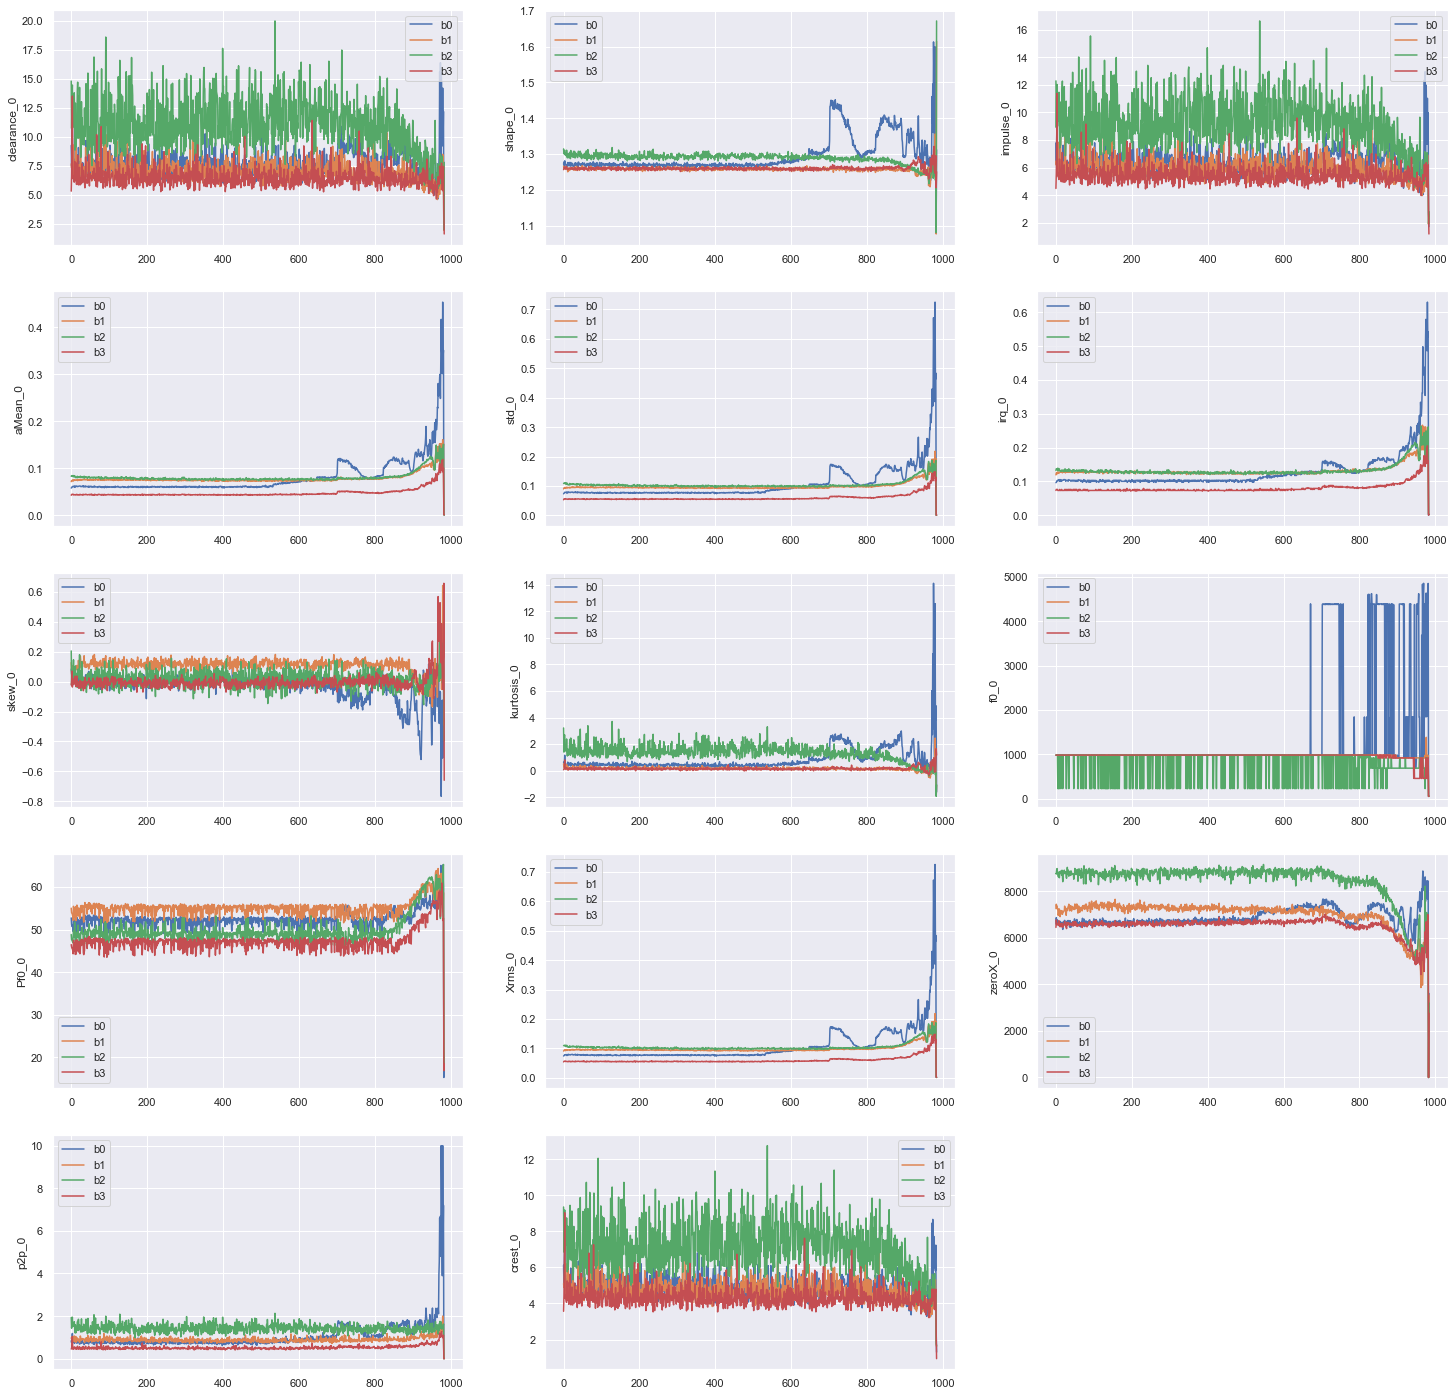

In [63]:
from matplotlib.pyplot import ylabel


plt.figure(figsize=(25,25))
plt.subplot(5,3,1)
sns.lineplot(x=df.index, y=df['clearance_0'], label='b0')
sns.lineplot(x=df.index, y=df['clearance_1'], label='b1')
sns.lineplot(x=df.index, y=df['clearance_2'], label='b2')
sns.lineplot(x=df.index, y=df['clearance_3'], label='b3')

plt.subplot(5,3,2)
sns.lineplot(x=df.index, y=df['shape_0'], label='b0')
sns.lineplot(x=df.index, y=df['shape_1'], label='b1')
sns.lineplot(x=df.index, y=df['shape_2'], label='b2')
sns.lineplot(x=df.index, y=df['shape_3'], label='b3')

plt.subplot(5,3,3)
sns.lineplot(x=df.index, y=df['impulse_0'], label='b0')
sns.lineplot(x=df.index, y=df['impulse_1'], label='b1')
sns.lineplot(x=df.index, y=df['impulse_2'], label='b2')
sns.lineplot(x=df.index, y=df['impulse_3'], label='b3')

plt.subplot(5,3,4)
sns.lineplot(x=df.index, y=df['aMean_0'], label='b0')
sns.lineplot(x=df.index, y=df['aMean_1'], label='b1')
sns.lineplot(x=df.index, y=df['aMean_2'], label='b2')
sns.lineplot(x=df.index, y=df['aMean_3'], label='b3')

plt.subplot(5,3,5)
sns.lineplot(x=df.index, y=df['std_0'], label='b0')
sns.lineplot(x=df.index, y=df['std_1'], label='b1')
sns.lineplot(x=df.index, y=df['std_2'], label='b2')
sns.lineplot(x=df.index, y=df['std_3'], label='b3')

plt.subplot(5,3,6)
sns.lineplot(x=df.index, y=df['irq_0'], label='b0')
sns.lineplot(x=df.index, y=df['irq_1'], label='b1')
sns.lineplot(x=df.index, y=df['irq_2'], label='b2')
sns.lineplot(x=df.index, y=df['irq_3'], label='b3')

plt.subplot(5,3,7)
sns.lineplot(x=df.index, y=df['skew_0'], label='b0')
sns.lineplot(x=df.index, y=df['skew_1'], label='b1')
sns.lineplot(x=df.index, y=df['skew_2'], label='b2')
sns.lineplot(x=df.index, y=df['skew_3'], label='b3')

plt.subplot(5,3,8)
sns.lineplot(x=df.index, y=df['kurtosis_0'], label='b0')
sns.lineplot(x=df.index, y=df['kurtosis_1'], label='b1')
sns.lineplot(x=df.index, y=df['kurtosis_2'], label='b2')
sns.lineplot(x=df.index, y=df['kurtosis_3'], label='b3')

plt.subplot(5,3,9)
sns.lineplot(x=df.index, y=df['f0_0'], label='b0')
sns.lineplot(x=df.index, y=df['f0_1'], label='b1')
sns.lineplot(x=df.index, y=df['f0_2'], label='b2')
sns.lineplot(x=df.index, y=df['f0_3'], label='b3')
       
plt.subplot(5,3,10)
sns.lineplot(x=df.index, y=df['Pf0_0'], label='b0')
sns.lineplot(x=df.index, y=df['Pf0_1'], label='b1')
sns.lineplot(x=df.index, y=df['Pf0_2'], label='b2')
sns.lineplot(x=df.index, y=df['Pf0_3'], label='b3')

plt.subplot(5,3,11)
sns.lineplot(x=df.index, y=df['Xrms_0'], label='b0')
sns.lineplot(x=df.index, y=df['Xrms_1'], label='b1')
sns.lineplot(x=df.index, y=df['Xrms_2'], label='b2')
sns.lineplot(x=df.index, y=df['Xrms_3'], label='b3')

plt.subplot(5,3,12)
sns.lineplot(x=df.index, y=df['zeroX_0'], label='b0')
sns.lineplot(x=df.index, y=df['zeroX_1'], label='b1')
sns.lineplot(x=df.index, y=df['zeroX_2'], label='b2')
sns.lineplot(x=df.index, y=df['zeroX_3'], label='b3')

plt.subplot(5,3,13)
sns.lineplot(x=df.index, y=df['p2p_0'], label='b0')
sns.lineplot(x=df.index, y=df['p2p_1'], label='b1')
sns.lineplot(x=df.index, y=df['p2p_2'], label='b2')
sns.lineplot(x=df.index, y=df['p2p_3'], label='b3')

plt.subplot(5,3,14)
sns.lineplot(x=df.index, y=df['crest_0'], label='b0')
sns.lineplot(x=df.index, y=df['crest_1'], label='b1')
sns.lineplot(x=df.index, y=df['crest_2'], label='b2')
sns.lineplot(x=df.index, y=df['crest_3'], label='b3')

### Selección de features

#### Normalidad de los features

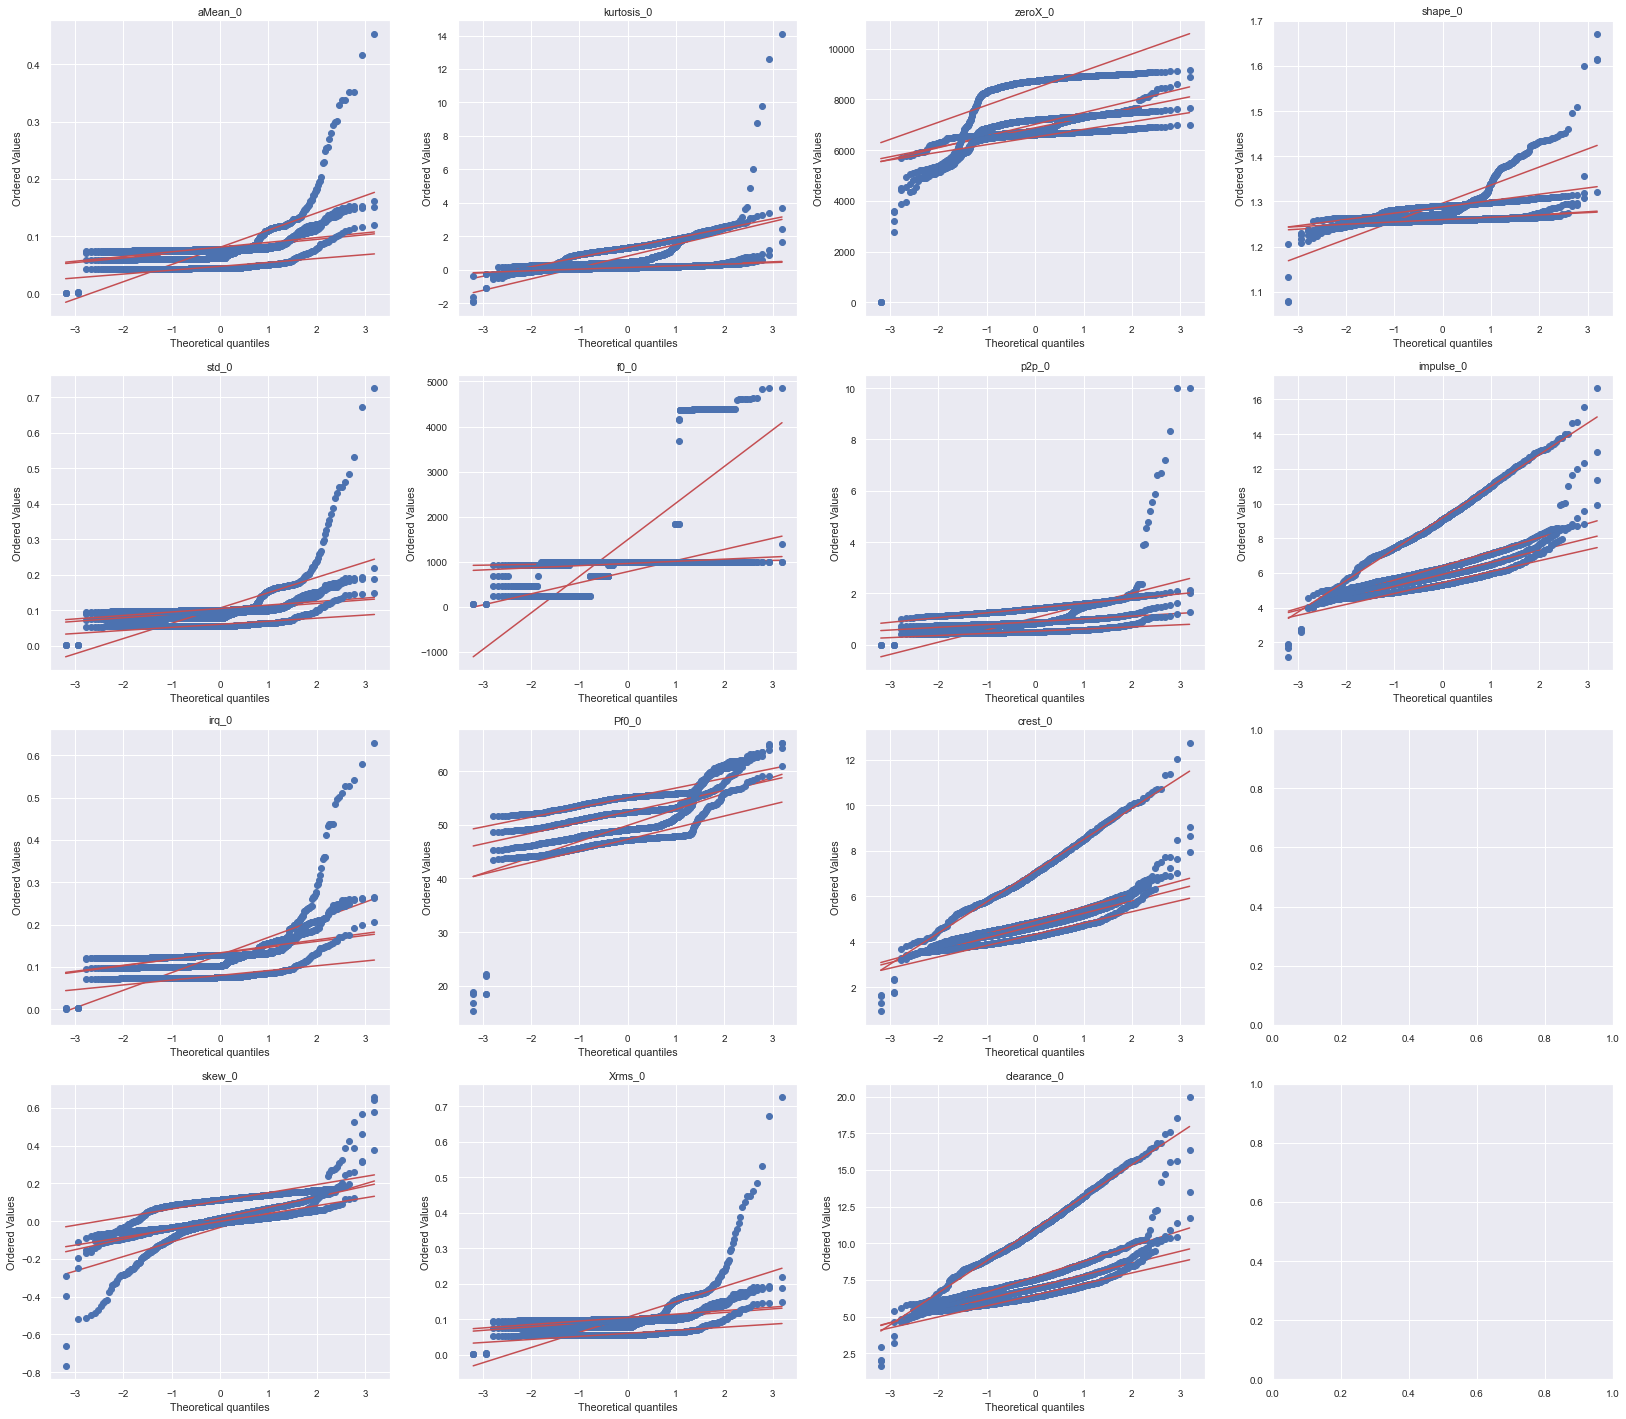

In [45]:
from scipy import stats
# Check conditions for using Pearson
plots_rows = 4
fig, axis = plt.subplots(plots_rows,4,figsize=(28,25)) 
for i in range(4):  # for each bearing
    col_offset = i * cols_per_bearing
    for k, xi in enumerate(np.array(df.iloc[:,col_offset:col_offset+cols_per_bearing]).T):
        if(k >= cols_per_bearing):
            break
        stats.probplot(xi, dist="norm", plot=axis[k%plots_rows,k//plots_rows])
        axis[k%plots_rows,k//plots_rows].set_title(df.columns.values[k])

# A partir de los gráficos, se puede ver que algunos features siguen distribuciones "casi" normales: p2p, crest, clearance, impulse
# Esta normalidad se mantiene para los 4 rodamientos a lo largo de todo el experimento, salvo en los momentos cercanos a la falla, 
# donde se puede ver una divergencia respecto a la distribución normal. 

#### Pearson vs Spearman

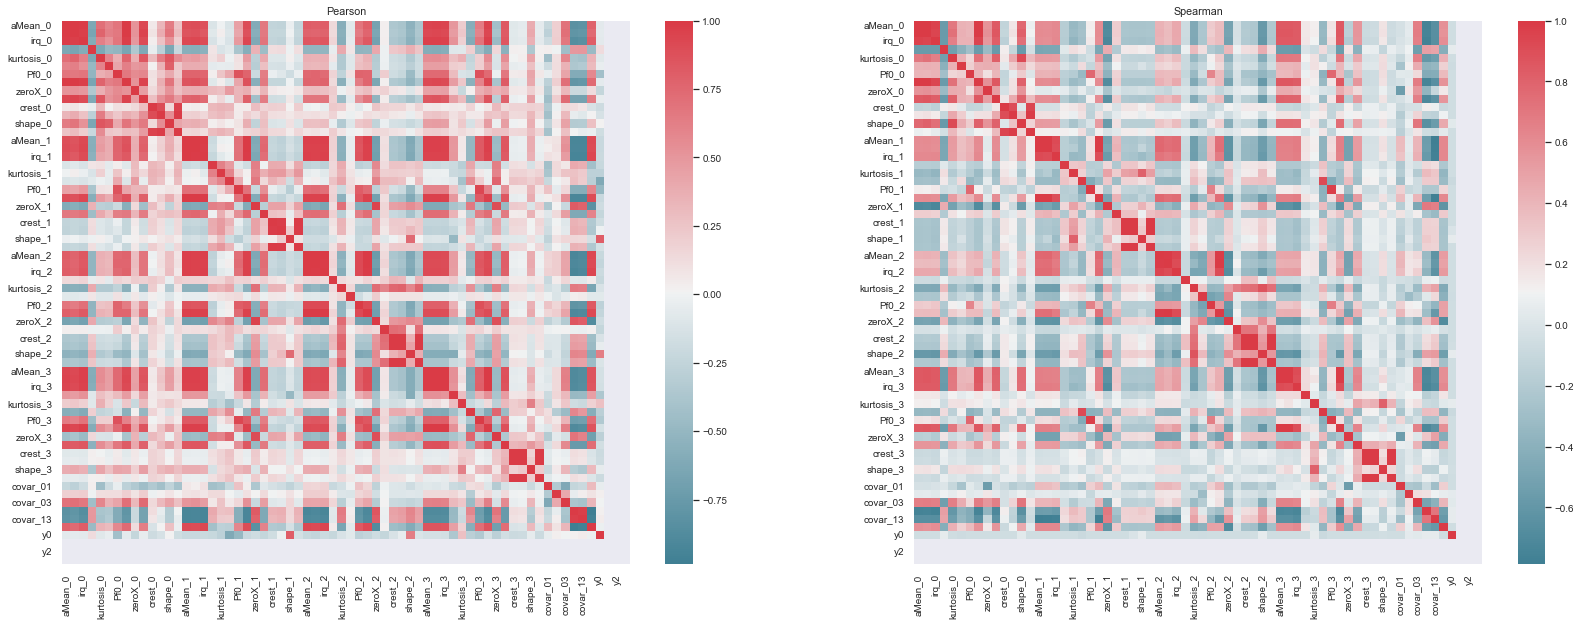

In [46]:

fig, axes = plt.subplots(1,2,figsize=(28,10))

corr_pearson = df.corr(method='pearson')
axes[0].set_title("Pearson")
sns.heatmap(corr_pearson, cmap=sns.diverging_palette(220,10,as_cmap=True),fmt=".2f",ax=axes[0])
sns.set(font_scale=0.9)

corr_spearman = df.corr(method='spearman')
axes[1].set_title("Spearman")
sns.heatmap(corr_spearman, cmap=sns.diverging_palette(220,10,as_cmap=True),fmt=".2f")
sns.set(font_scale=0.9)

In [52]:
# Ahora, determinamos cuales features son candidatas a quitar según la correlación con otras features, para así reducir las dimensiones de nuestro dataset.
# Para eso, fijamos un threshold de 95% de correlación.
threshold = 0.95
corr_tril_pe = np.triu(corr_pearson, k=1)   # Keep the upper triangle for Pearson
corr_tril_sp = np.triu(corr_spearman, k=1)   # Keep the upper triangle for Spearman
indices_pe = np.where(abs(corr_tril_pe) >= threshold)
indices_sp = np.where(abs(corr_tril_sp) >= threshold)
# dims_to_del.update(indices_pe[1])  # Add the dimensions that correspond to a pearson coef greater than the threshold
print('Dims to delete for ' + str(threshold) + ' threshold: ')
pairs_pe = list(zip(df.columns[indices_pe[0]].tolist(), df.columns[indices_pe[1]].tolist()))
pairs_sp = list(zip(df.columns[indices_sp[0]].tolist(), df.columns[indices_sp[1]].tolist()))
print("\n Pearson: ", pairs_pe)
print("\n Spearman: ", pairs_sp)

Dims to delete for 0.95 threshold: 

 Pearson:  [('aMean_0', 'std_0'), ('aMean_0', 'irq_0'), ('aMean_0', 'Xrms_0'), ('std_0', 'irq_0'), ('std_0', 'Xrms_0'), ('std_0', 'p2p_0'), ('irq_0', 'Xrms_0'), ('irq_0', 'aMean_3'), ('irq_0', 'std_3'), ('irq_0', 'irq_3'), ('irq_0', 'Xrms_3'), ('Xrms_0', 'p2p_0'), ('crest_0', 'impulse_0'), ('clearance_0', 'impulse_0'), ('aMean_1', 'std_1'), ('aMean_1', 'irq_1'), ('aMean_1', 'Xrms_1'), ('aMean_1', 'aMean_2'), ('aMean_1', 'std_2'), ('aMean_1', 'irq_2'), ('aMean_1', 'Xrms_2'), ('aMean_1', 'aMean_3'), ('aMean_1', 'std_3'), ('aMean_1', 'irq_3'), ('aMean_1', 'Xrms_3'), ('std_1', 'irq_1'), ('std_1', 'Xrms_1'), ('std_1', 'aMean_2'), ('std_1', 'std_2'), ('std_1', 'irq_2'), ('std_1', 'Xrms_2'), ('std_1', 'aMean_3'), ('std_1', 'std_3'), ('std_1', 'irq_3'), ('std_1', 'Xrms_3'), ('irq_1', 'Xrms_1'), ('irq_1', 'aMean_2'), ('irq_1', 'std_2'), ('irq_1', 'irq_2'), ('irq_1', 'Xrms_2'), ('irq_1', 'aMean_3'), ('irq_1', 'std_3'), ('irq_1', 'Xrms_3'), ('Xrms_1', 'aMean_2

In [84]:
# Para la selección, se consideró que la correlación esté presente para los 4 rodamientos ya que no queremos introducir asimetría en el tratamiento de cada rodamiento.
# Además, se utilizó la correlación de Spearman, ya que, según vimos durante la exploración del dataset, un gran indicador de que un rodamiento se encuentra próximo a su 
# falla es cuando la variable comienza a aumentar o disminuir (respecto a su valor estacionario). Por lo tanto, si nuestro interes ahora es reducir las dimensiones, con buscar
# una relación monotónica entre dos features (Spearman) nos permite reducir una dimensión mientras que mantener la información de la falla.
# Podemos ver que las siguientes features están altamente correlacionadas:
# aMean <-> std
# aMean <-> Xrms
# std <-> Xrms
# crest <-> impulse
# clearance <-> impulse
features_to_del = [ 'aMean', 'std', 'impulse']

dims_to_del_id = []
for j in range(4):
    dims_to_del_id.append([(single_features[i]+cols_per_bearing*j) for i in features_to_del])
dims_to_del_id = np.array(dims_to_del_id).flatten()
dims_to_del_name = df.columns[dims_to_del_id].to_list()
print("Se borrarán las siguientes features: \n", dims_to_del_name)


Se borrarán las siguientes features: 
 ['aMean_0', 'std_0', 'impulse_0', 'aMean_1', 'std_1', 'impulse_1', 'aMean_2', 'std_2', 'impulse_2', 'aMean_3', 'std_3', 'impulse_3']


In [86]:
# Drop highly correlated features
df_red = df.drop(dims_to_del_name, axis=1)
df_red.describe()
# for i in range(4):
#     df_red = df_red.drop(['aMean_'+str(i)], axis=1)
#     df_red = df_red.drop(['std_'+str(i)], axis=1)


,irq_0,skew_0,kurtosis_0,f0_0,Pf0_0,Xrms_0,zeroX_0,p2p_0,crest_0,clearance_0,...,covar_01,covar_02,covar_03,covar_12,covar_13,covar_23,y0,y1,y2,y3
count,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,...,984.000000,984.000000,984.000000,984.000000,9.840000e+02,9.840000e+02,984.000000,984.0,984.0,984.0
mean,0.128091,-0.033123,0.827138,1488.989853,52.411202,0.106111,6879.347561,1.054736,4.938415,7.717352,...,0.001577,-0.000474,-0.000045,-0.001310,-1.368870e-03,7.654559e-04,0.001016,0.0,0.0,0.0
std,0.058001,0.089029,0.965787,1202.293360,2.529818,0.058224,442.081350,0.740102,0.599819,1.111353,...,0.001227,0.000621,0.001092,0.002179,1.020015e-03,1.083733e-03,0.031879,0.0,0.0,0.0
min,0.000000,-0.766067,-1.609774,58.593750,15.223287,0.001533,0.000000,0.005000,1.304860,2.937687,...,-0.016802,-0.006265,-0.003449,-0.017709,-9.969288e-03,5.918902e-07,0.000000,0.0,0.0,0.0
25%,0.100000,-0.047506,0.393747,985.351562,51.522408,0.077137,6649.750000,0.752000,4.575072,7.013623,...,0.001407,-0.000580,-0.000314,-0.001028,-1.180721e-03,3.675887e-04,0.000000,0.0,0.0,0.0
50%,0.103000,-0.009859,0.484787,985.351562,52.352332,0.078778,6759.500000,0.830000,4.889787,7.554930,...,0.001508,-0.000503,-0.000262,-0.000590,-1.048524e-03,4.074848e-04,0.000000,0.0,0.0,0.0
75%,0.131000,0.013705,0.878688,985.351562,52.871842,0.108819,7161.000000,1.101750,5.222041,8.268537,...,0.001630,-0.000414,-0.000092,-0.000482,-9.966261e-04,5.216813e-04,0.000000,0.0,0.0,0.0
max,0.630000,0.579698,14.110009,4849.609375,65.182241,0.725001,8870.000000,9.998000,8.663341,16.374282,...,0.010003,0.010375,0.019175,0.000025,6.124187e-07,8.906680e-03,1.000000,0.0,0.0,0.0
